In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading and Cleaning Data

In [115]:
# Load the processed data
raw_df = pd.read_csv('../data/processed/manifest_features.csv')
print(f"SHAPE: {raw_df.shape}")
raw_df.head(1)

SHAPE: (75000, 28)


,sample_id,catalog_content,image_link,price,text_len,has_image,image_status,value,pack_count,bullet_count,...,sentiment_score,unit_Count,unit_Kg,unit_L,unit_Ounce,unit_Oz,unit_Unknown,unit_g,unit_ml,unit_nan
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,91,True,not_checked,72.0,6,0,...,0.298296,False,False,False,True,False,False,False,False,False


In [116]:
# Dropping featureless columns
df = raw_df.drop(columns=['sample_id','catalog_content','image_link','image_status','sentiment_label'])

# Convert boolean columns to int
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

# Fill missing values
df['pack_count'] = df['pack_count'].fillna(1)
df['value'] = df['value'].fillna(0)
df['has_image'] = df['has_image'].fillna(0)
df['unit_nan'] = df['unit_nan'].fillna(0)

### Computing New Features

In [117]:
def compute_total_weight(row):
    val = row['value']
    count = row['pack_count']
    if row.get('unit_Count', 0):
        return val * count
    elif row.get('unit_Kg', 0):
        return val * 1000 * count
    elif row.get('unit_g', 0):
        return val * 1 * count
    elif row.get('unit_L', 0):
        return val * 1000 * count
    elif row.get('unit_ml', 0):
        return val * 1 * count
    elif row.get('unit_Ounce', 0) or row.get('unit_Oz', 0):
        return val * 28.3495 * count
    elif row.get('unit_Fl_Oz', 0):
        return val * 29.5735 * count
    else:
        return np.nan
    
df['total_weight'] = df.apply(compute_total_weight, axis=1).fillna(0)
df['text_len_x_digit_count'] = df['text_len'] * df['digit_count']
df['text_len_x_bullet_count'] = df['text_len'] * df['bullet_count']
df['pack_count_x_total_weight'] = df['pack_count'] * df['total_weight']


### Applying Log Transformation

#### Log-transforming Total Weight

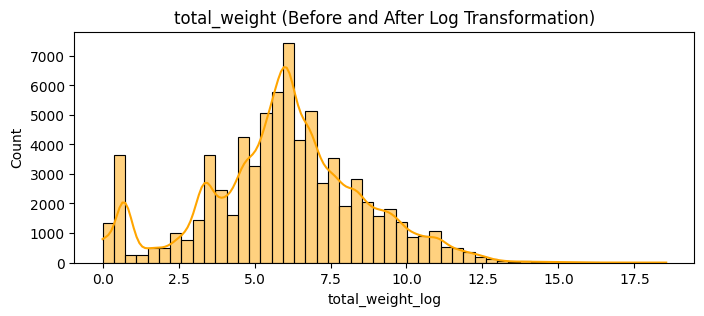

In [130]:
# Applying Log Transformation
df['total_weight_log'] = np.log1p(df['total_weight'])
plt.figure(figsize=(8,3))
sns.histplot(df['total_weight_log'], bins=50, kde=True, color='orange', label='Log Transformed')
plt.title('total_weight (Before and After Log Transformation)')
plt.show()

#### Log-transforming text_len_x_digit_count

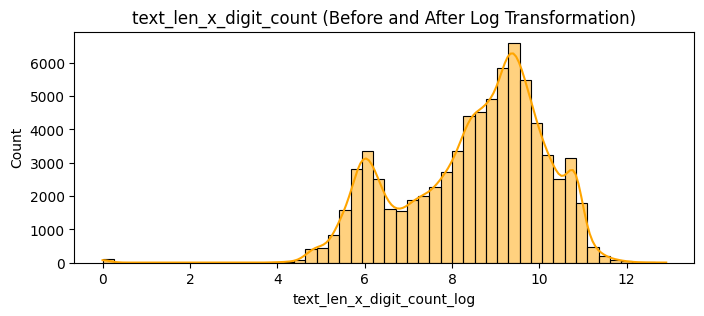

In [129]:
# Applying Log Transformation
df['text_len_x_digit_count_log'] = np.log1p(df['text_len_x_digit_count'])
plt.figure(figsize=(8,3))
sns.histplot(df['text_len_x_digit_count_log'], bins=50, kde=True, color='orange', label='Log Transformed')
plt.title('text_len_x_digit_count (Before and After Log Transformation)')
plt.show()

#### Log-Tranformation text_len_x_bullet_count

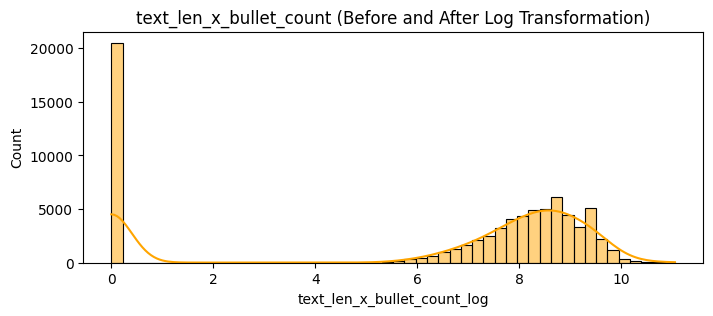

In [128]:
# Apply Log Transformation
df['text_len_x_bullet_count_log'] = np.log1p(df['text_len_x_bullet_count'])
plt.figure(figsize=(8,3))
sns.histplot(df['text_len_x_bullet_count_log'], bins=50, kde=True, color='orange', label='Log Transformed')
plt.title('text_len_x_bullet_count (Before and After Log Transformation)')
plt.show()

#### Log-transforming pack_count_x_total_weight

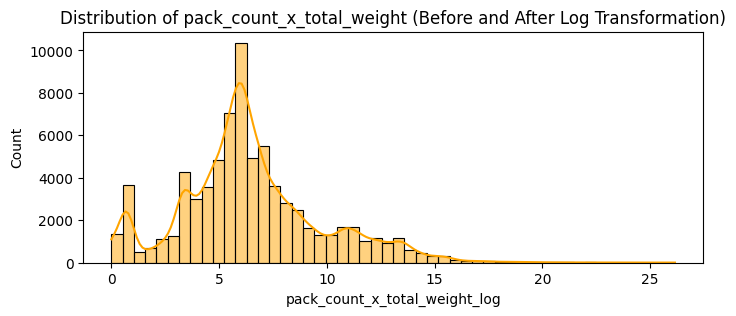

In [126]:
df['pack_count_x_total_weight_log'] = np.log1p(df['pack_count_x_total_weight'])
plt.figure(figsize=(8,3))
sns.histplot(df['pack_count_x_total_weight_log'], bins=50, kde=True, color='orange', label='Log Transformed')
plt.title('Distribution of pack_count_x_total_weight (Before and After Log Transformation)')
plt.show()

### Correlation Analysis

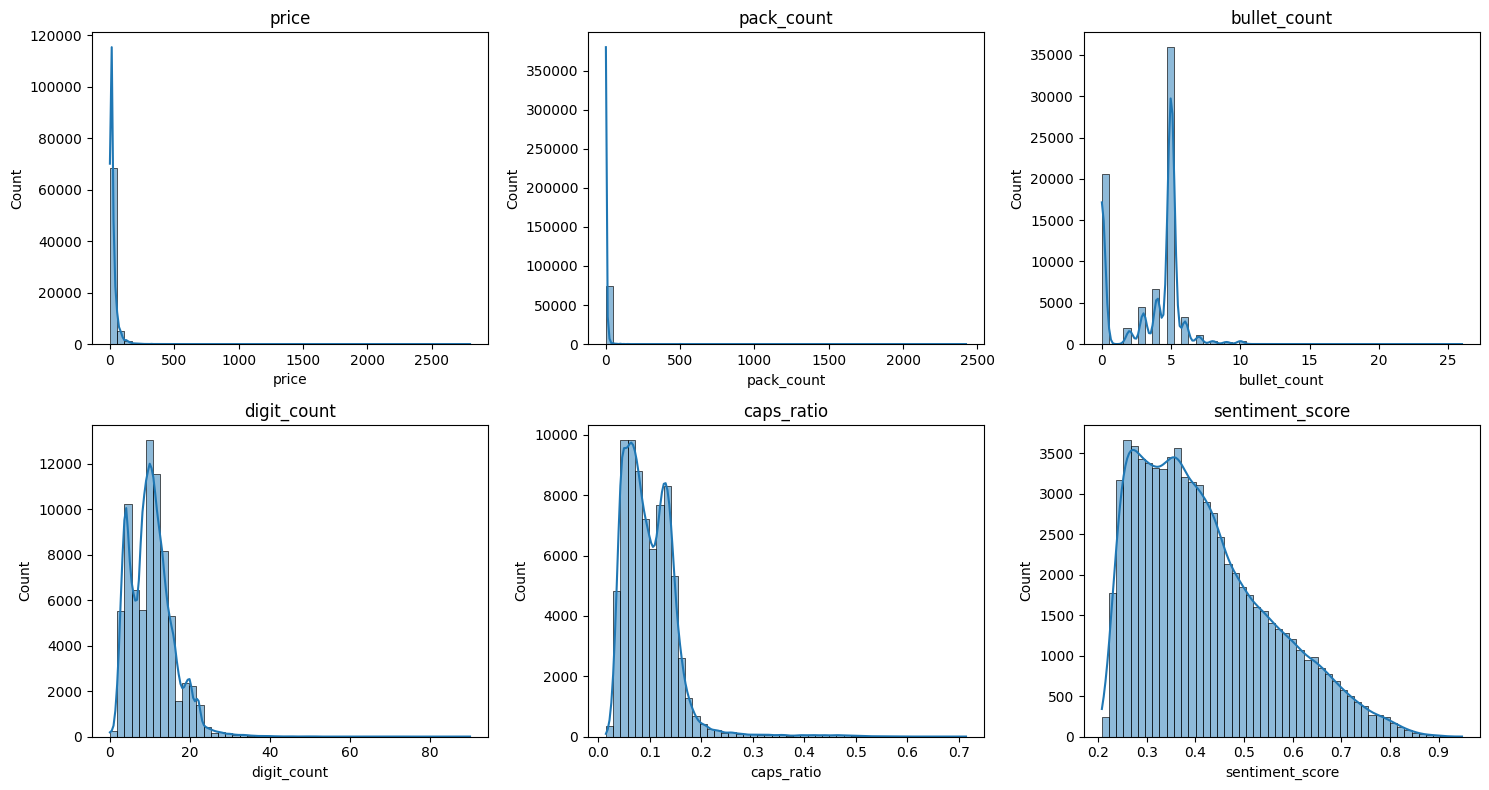

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for i, col in enumerate(["price", "pack_count", "bullet_count", "digit_count", "caps_ratio", "sentiment_score"]):
    sns.histplot(df[col], bins=50, ax=axes[i//3, i%3], kde=True)
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

In [12]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['sample_id', 'catalog_content', 'image_link']]
for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head(5))


Value counts for image_status:
image_status
not_checked    74663
ok               337
Name: count, dtype: int64

Value counts for sentiment_label:
sentiment_label
5 stars    36981
1 star     18054
4 stars    16468
3 stars     2858
2 stars      639
Name: count, dtype: int64


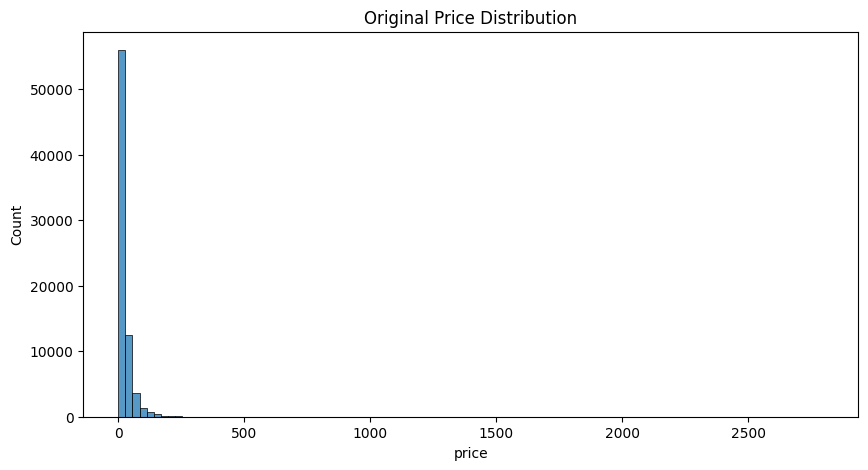

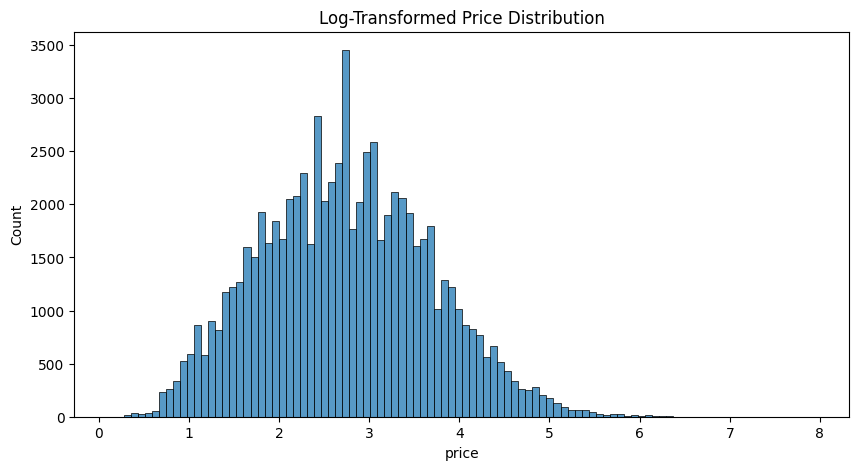

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df["price"], bins=100)
plt.title("Original Price Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df["price"]), bins=100)
plt.title("Log-Transformed Price Distribution")
plt.show()

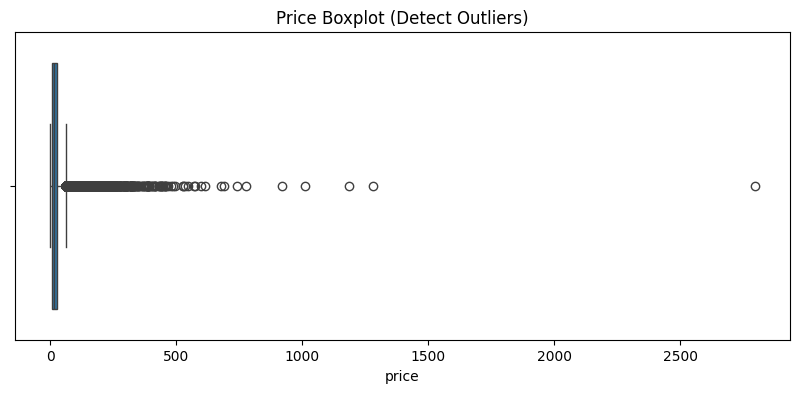

In [15]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df["price"])
plt.title("Price Boxplot (Detect Outliers)")
plt.show()

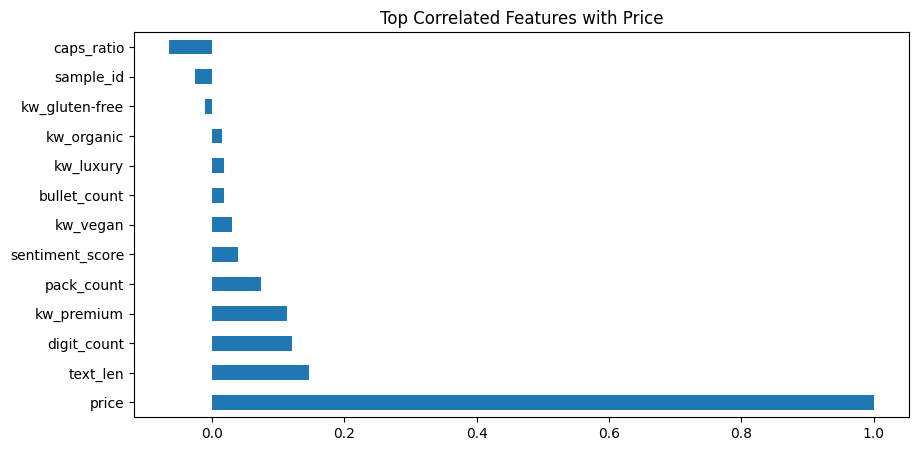

In [16]:
corr_price = df[num_cols].corrwith(df["price"]).sort_values(ascending=False)
plt.figure(figsize=(10,5))
corr_price.head(15).plot(kind="barh")
plt.title("Top Correlated Features with Price")
plt.show()

In [17]:
print("Total duplicates:", df.duplicated(subset=["sample_id"]).sum())
print("Total null rows:", df.isnull().any(axis=1).sum())

Total duplicates: 0
Total null rows: 0


ValueError: could not convert string to float: 'Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n'